# File Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import math
import sys
import os
import itertools
from IPython.core.display import HTML

### Create supporting Functions

In [19]:
# get file name 
file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format('k14','85','85')

# Load the data
ds = netCDF4.Dataset(file)

# Extract the variables
site_id = np.array(ds.variables['id'])
lat = np.array(ds.variables['lat'])
long = np.array(ds.variables['lon'])

# create dataframe of all site locations
df_sites = pd.DataFrame({'site':site_id,'lat':lat,'long':long})


In [20]:

list_of_locations = \
    {"top":{'lat':-37.079162, 'long':175.517736},
    "bottom":{'lat':-37.176977, 'long':175.513385}
    }



def find_closest_site(lat,long,df_sites):
    '''
    
    '''
    df_sites['lat-loc'] = np.abs(df_sites.lat-lat)
    df_sites['long-loc'] = np.abs(df_sites.long-long)
    df_sites['distance'] = [np.sqrt(x**2+y**2) for x,y in zip(df_sites['lat-loc'],df_sites['long-loc'])]
    closest_site = df_sites[df_sites.distance==np.min(df_sites['distance'])]
#     closest_site_id = closest_site.reset_index().loc[0,'site']
    
    closest_site = closest_site.rename(columns={'lat':'closest_lat','long':'closest_long'})
    
    return(closest_site)

closest_site_dict = {}

for key,item in list_of_locations.items():
    closest_site = find_closest_site(item['lat'],item['long'],df_sites)
    
    closest_site_dict.update({
        key:closest_site
    })
    
min_site = np.min([closest_site_dict['top'].site,closest_site_dict['bottom'].site])
max_site = np.max([closest_site_dict['top'].site,closest_site_dict['bottom'].site])

df_sites = df_sites[(df_sites.site>(min_site+3))&(df_sites.site<max_site)]

# Create list of sites
sites_list = list(df_sites.site)

# NZ SLR points for Richard

In [21]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp in rcps:

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)
        
        # Load the data
        ds = netCDF4.Dataset(file)
            
        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)
        
        quantiles_across_sites = {}
            
        for index,row in df_sites.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]

            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
                    'lat':row.lat,
                    'long':row.long,
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


# Create a Video

In [22]:

ais_config = 'k14v'
rcp_config = '26'

slr_range_dict = {}

for idx in range(len(AIS_scenarios[ais_config]['26']['quantiles_dict'][sites_list[0]]['median']['SLR'])):
    max_slr_year_idx = \
    np.max([AIS_scenarios[ais_config][rcp_config]['quantiles_dict'][site]['median']['SLR'].reset_index(drop=True)[idx]
     for site in AIS_scenarios[ais_config][rcp_config]['quantiles_dict'].keys()])

    min_slr_year_idx = \
    np.min([AIS_scenarios[ais_config][rcp_config]['quantiles_dict'][site]['median']['SLR'].reset_index(drop=True)[idx]
     for site in AIS_scenarios[ais_config][rcp_config]['quantiles_dict'].keys()])

    slr_range_dict.update({
        idx:{
            'min':min_slr_year_idx,
            'max':max_slr_year_idx
        }
    })
    
df_slr_range = pd.DataFrame.from_dict(slr_range_dict).T


In [23]:
import io
from urllib.request import urlopen, Request
from PIL import Image
import pickle

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

running


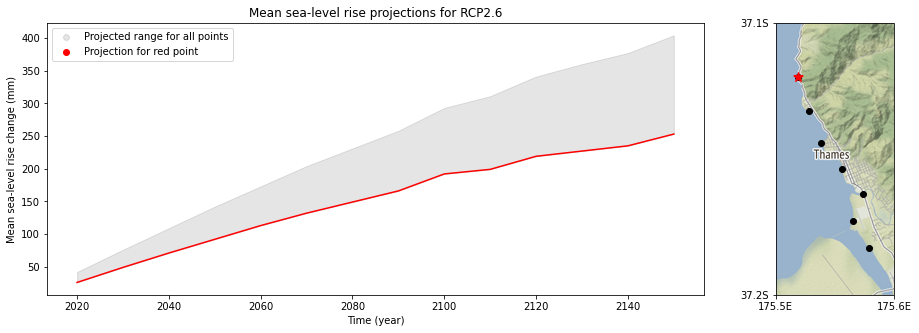

In [27]:
%matplotlib inline

print('running')

# Set up the figure
fig1 = plt.figure(figsize=(20,10))
fig1.subplots_adjust(wspace=-0.3,hspace=0)

fig1.tight_layout()

gs = fig1.add_gridspec(2, 2)

### Setup axes
ax1 = fig1.add_subplot(gs[0,0])

# Add range of outputs as background
ax1.fill_between(x=list(AIS_scenarios[ais_config][rcp_config]['quantiles_dict'][sites_list[0]]['median']['year']),
                 y1=list(df_slr_range['min']),
                 y2=list(df_slr_range['max']),
                 zorder=-10000,
                 color='k',
                 alpha=0.1)  

ax1.set_ylabel('Mean sea-level rise change (mm)')
ax1.set_xlabel('Time (year)')

l1 = plt.scatter([],[],c='k',alpha=0.1)
#     l2 = plt.scatter([],[],c='b')
l3 = plt.scatter([],[],c='r')
#     l4 = plt.scatter([],[],c='g')

ax1.legend([l1,l3],['Projected range for all points','Projection for red point'],loc='upper left')
ax1.set_title('Mean sea-level rise projections for RCP{}'.format(rcp_config[0]+'.'+rcp_config[1]))

cimgt.Stamen.get_image = image_spoof  ## test 
stamen_terrain = cimgt.Stamen('terrain')
ax2 = fig1.add_subplot(gs[0,1],projection=stamen_terrain.crs)

# Add the Stamen data at zoom level 8.
ax2.add_image(stamen_terrain, 12, interpolation='spline36')

# Adjust axes
ax2.set_extent([np.min(df_sites.long)-0.01,np.max(df_sites.long)+0.01,np.min(df_sites.lat)-0.01,np.max(df_sites.lat)+0.01])
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax2.xaxis.set_major_formatter(lon_formatter) # set lons
ax2.yaxis.set_major_formatter(lat_formatter) # set lats

# Plot background points
ax2.scatter(df_sites.long,df_sites.lat,c='k',transform=ccrs.Geodetic())

scats = []
lines = []

def animate(i):
    global scats
    # first remove all old scatters
    for scat in scats:
        scat.remove()
    scats=[]
    
    global lines
    for line in lines:
        line.remove()
    lines=[]
    
    # now draw new scatters
    scats.append(ax2.scatter(df_sites[df_sites.site==sites_list[i]].long,df_sites[df_sites.site==sites_list[i]].lat,
            transform=ccrs.Geodetic(),c='r',marker='*',zorder=1000,s=100))  
    line, = ax1.plot(AIS_scenarios[ais_config][rcp_config]['quantiles_dict'][sites_list[0]]['median']['year'],
                     AIS_scenarios[ais_config][rcp_config]['quantiles_dict'][sites_list[i]]['median']['SLR'],c='r')
    lines.append(line)
    
    # Set ticks for map
    ax2.set_yticks(range(1),range(1))
    ax2.set_xticks(range(1),range(1))
    
    X = ax2.get_xticks()
    Y = ax2.get_yticks()

    ax2.set_xticks([X[0],X[-1]])
    ax2.set_yticks([Y[0],Y[-1]])
            

anim = matplotlib.animation.FuncAnimation(fig1, animate, interval=400,frames=len(sites_list))

writer = matplotlib.animation.FFMpegWriter(fps=15, 
            codec="h264", 
            extra_args=["-preset", "veryslow","-crf","0"])

# Send the animation to string
html = HTML(anim.to_jshtml()).data

with open('thames_example_animation.html', 'w') as f:
    f.write(html)

In [25]:
transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32659"),pyproj.CRS("epsg:4326"))

XY = [transformer.transform(x,y) for x,y in zip(X,Y)]

XY

NameError: name 'pyproj' is not defined

In [ ]:
extent = [np.min(df_sites.long)-0.01,np.max(df_sites.long)+0.01,np.min(df_sites.lat)-0.01,np.max(df_sites.lat)+0.01]

In [ ]:
def decdeg2dms(dd):
    mnt,sec = divmod(dd*3600,60)
    deg,mnt = divmod(mnt,60)
    string = u"{}$^\circ${}'{}\"".format(deg,mnt,sec)
    return(string)

[decdeg2dms(x) for x in extent]

In [ ]:
ax1.fill_between(x=AIS_scenarios[ais_config]['26']['quantiles_dict'][sites_list[0]]['median']['year'],
                 y1=list(df_slr_range['min']),
                 y2=list(df_slr_range['max']),
                 zorder=-10000,
                 color='k',
                 alpha=0.1)

In [ ]:
AIS_scenarios[ais_config]['26']['quantiles_dict'][sites_list[0]]['median']['year']

In [ ]:
AIS_scenarios[ais_config]['26']['quantiles_dict'][sites_list[0]]['median']['year']

In [ ]:
list(df_slr_range['min'])

In [ ]:
df_sites.index